In [1]:
__nbid__ = '0032'
__author__ = 'Alice Jacques <alice.jacques@noirlab.edu>'
__version__ = '20240606' # yyyymmdd
__datasets__ = ['gaia_dr3']
__keywords__ = ['science example', 'stars', 'parallax', 'vospace']

# Using Gaia DR3 to identify hyper-runaway and hypervelocity white dwarf candidates

### Table of contents
* [Goals & summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#imports)
* [Authentication](#auth)
* [Query Gaia DR3 part I: for HVS WD candidates](#query)
* [Query Gaia DR3 part II: for objects within 100 pc](#query100pc)
* [HR diagram for WDs and sdBs candidates](#hr)
* [Galactocentric distances and heights above/below the Galactic plane for HVS WD candidates](#galacto)
* [Heights above/below the Galactic plane of the observed HVS WD candidates](#heights)
* [Resources and references](#ref)

<a class="anchor" id="goals"></a>
# Goals
To reproduce Figures 1, 3, and 4 from [Igoshev et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.6223I/abstract) "Hyper-runaway and hypervelocity white dwarf candidates in Gaia Data Release 3: possible remnants from Ia/Iax supernova explosions or dynamical encounters". These figures show the locations of 46 hyper-runaway/hypervelocity (HVS) white dwarf (WD) candidates on the Hertzsprung–Russell diagram as well as their transversal velocities and heights above/below the Galactic plane.


# Summary
In their paper, Igoshev et al. use data from Gaia DR3 (Gaia Collaboration et al. [2016b](https://gea.esac.esa.int/archive/documentation/GDR3/bib.html#bib375) and [2022k](https://gea.esac.esa.int/archive/documentation/GDR3/bib.html#bib179)) to search for and analyze white dwarfs and other peculiar objects possibly ejected from the Galactic disk at very high velocities (> 400 km/s) because of thermonuclear type Ia/Iax peculiar supernovae (SNe) or dynamical encounters. 

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="imports"></a>
# Imports and setup

In [2]:
# Standard lib
from getpass import getpass

# 3rd party imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# Data Lab
from dl import authClient as ac, queryClient as qc

# plots default setup
plt.rcParams['font.size'] = 14

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

<a class="anchor" id="query"></a>
# Query Gaia DR3 part I: for HVS WD candidates
The following query can be executed in order to extract potential hyper-runaway/hypervelocity (HVS) white dwarf (WD) candidates from the `gaia_dr3.gaia_source` table at Astro Data Lab. Since the query runtime takes about 40 minutes, we have commented out the cell that would actually execute the query and instead import the resulting table (from executing the query prior to now).

The following constraints are applied in the query in order to exclude objects with large uncertainties:

(1) parallax / parallax uncertainty > 4  
    --> `parallax_over_error > 4`  
(2) parallax > 0.25 mas (i.e. objects with nominal distances that are smaller than 4 kpc)  
    --> `parallax > 0.25`  
(3) renormalized unit weight error (RUWE) < 1.4  
    --> `ruwe < 1.4`  
(4) Percent of successful-IPD windows with more than one peak <= 2  
    --> `ipd_frac_multi_peak <= 2`  
(5) Amplitude of the IPD GoF versus position angle of scan < 0.1  
    --> `ipd_gof_harmonic_amplitude < 0.1`  
(6) Matched FOV transits used in the AGIS solution < 1.5  
    --> `astrometric_sigma5d_max < 1.5`  
(7) G_abs > 6 + 5*(G_BP - G_RP) (color-magnitude cut suggested by [Gentile Fusillo et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3877G/abstract))  
    --> `phot_g_mean_mag - 5 * log10(1000.0 / parallax) + 5 > 6 + 5 * (bp_rp)`

In [4]:
q = """
SELECT TOP 10000
    source_id, phot_g_mean_mag, bp_rp, parallax, parallax_over_error,
    pm, b, l, ecl_lat, ecl_lon, ruwe, 4.74*(ABS(pm)/parallax) AS v
FROM 
    gaia_dr3.gaia_source
WHERE
    parallax_over_error > 4
    AND parallax > 0.25
    AND ruwe < 1.4
    AND ipd_frac_multi_peak <= 2
    AND ipd_gof_harmonic_amplitude < 0.1
    AND astrometric_sigma5d_max < 1.5
    AND phot_g_mean_mag - 5 * log10(1000.0 / parallax) + 5 > 6 + 5 * (bp_rp)
ORDER BY v DESC
"""
print(q)


SELECT TOP 10000
    source_id, phot_g_mean_mag, bp_rp, parallax, parallax_over_error,
    pm, b, l, ecl_lat, ecl_lon, ruwe, 4.74*(ABS(pm)/parallax) AS v
FROM 
    gaia_dr3.gaia_source
WHERE
    parallax_over_error > 4
    AND parallax > 0.25
    AND ruwe < 1.4
    AND ipd_frac_multi_peak <= 2
    AND ipd_gof_harmonic_amplitude < 0.1
    AND astrometric_sigma5d_max < 1.5
    AND phot_g_mean_mag - 5 * log10(1000.0 / parallax) + 5 > 6 + 5 * (bp_rp)
ORDER BY v DESC



In [5]:
# Uncomment the following line to run the 40-minute query and save the output to VOSpace
#re = qc.query(adql=q,async_=True,wait=True,poll=180,verbose=1,timeout=8000,fmt='csv',out='vos://gaia_hvs.csv')

<a class="anchor" id="query100pc"></a>
# Query Gaia DR3 part II: for objects within 100 pc
The following query can be executed in order to extract objects within 100 pc of the sun from the `gaia_dr3.gaia_source` table at Astro Data Lab. Since the query runtime takes about 20 minutes, we have commented out the cell that would actually execute the query and instead import the resulting table (from executing the query prior to now).

In [6]:
q = """
SELECT TOP 250000
    phot_g_mean_mag, bp_rp, parallax
FROM
    gaia_dr3.gaia_source
WHERE 
    parallax > 10
    AND parallax_over_error > 10 
    AND phot_bp_mean_flux_over_error > 10
    AND phot_rp_mean_flux_over_error > 10
    AND bp_rp != 'NaN'
    AND parallax != 'NaN'
    AND ruwe < 1.4
    AND ipd_frac_multi_peak < 2
    AND ipd_gof_harmonic_amplitude < 0.1
    AND astrometric_sigma5d_max < 1.5
"""
print(q)


SELECT TOP 250000
    phot_g_mean_mag, bp_rp, parallax
FROM
    gaia_dr3.gaia_source
WHERE 
    parallax > 10
    AND parallax_over_error > 10 
    AND phot_bp_mean_flux_over_error > 10
    AND phot_rp_mean_flux_over_error > 10
    AND bp_rp != 'NaN'
    AND parallax != 'NaN'
    AND ruwe < 1.4
    AND ipd_frac_multi_peak < 2
    AND ipd_gof_harmonic_amplitude < 0.1
    AND astrometric_sigma5d_max < 1.5



In [7]:
# Uncomment the following line to execute the 21min query and save output to VOSpace
#re = qc.query(adql=q,async_=True,wait=True,poll=180,verbose=1,timeout=8000,fmt='csv',out='vos://gaia100pc.csv')

### Import the CSV files as Pandas Dataframes
We didn't run the actual queries, so we now read in the results from CSV files, using Pandas.

In [8]:
df_hvs = pd.read_csv('gaia_hvs.csv')
df_100pc = pd.read_csv('gaia100pc.csv')

From our resulting HVS WD candidate list, keep only those that have a nominal two-dimensional velocity (`v`) greater than 400 km/s.

In [9]:
df_hvs = df_hvs[df_hvs['v'] > 400]
print(f"Number of HVS WD candidates: {len(df_hvs)}")
df_hvs

Number of HVS WD candidates: 46


,source_id,phot_g_mean_mag,bp_rp,parallax,parallax_over_error,pm,b,l,ecl_lat,ecl_lon,ruwe,v
0,5703888058542880896,19.597963,0.322973,1.361697,4.278472,207.876310,13.599432,245.993343,-37.630457,141.643368,0.982530,723.606972
1,3688712561723372672,18.766459,-0.016319,1.419275,7.231967,211.641890,61.822172,306.715100,4.852452,193.869764,1.008971,706.827620
2,6368583523760274176,16.869844,-0.374060,0.307886,4.725116,36.638474,-33.492952,316.983358,-55.462151,286.838664,1.049720,564.059875
3,6416314659255288704,20.001963,0.335079,1.893672,4.914148,221.716230,-28.731589,322.764442,-49.805712,280.409670,1.025437,554.971949
4,6841322701358236416,19.097380,0.016804,2.787141,6.454955,321.476530,-42.125951,35.729228,-1.036853,319.736853,1.058983,546.724665
5,5808675437975384320,19.800177,-0.026350,2.055741,5.592335,232.483370,-15.014658,320.480755,-46.940755,259.895155,1.009515,536.045778
6,4376935406816933120,17.927696,-0.150414,2.056039,19.390610,231.208560,19.294956,26.834778,26.769946,262.120461,0.989464,533.029034
7,4739233769591077376,19.407776,-0.340424,1.473667,6.882322,165.588090,-55.996983,282.717935,-63.432466,352.094213,1.033190,532.608429
8,6640949596389193856,17.880573,0.288610,1.741432,11.009797,193.174640,-28.516559,341.862553,-33.625771,286.268124,1.046736,525.801773
9,4753345692095875328,19.539387,0.849884,6.489097,24.482530,714.484100,-60.610271,261.984526,-57.735627,13.238637,1.107528,521.899165


<a class="anchor" id="hr"></a>
## HR diagram for WDs and sdBs candidates
Below is the Hertzsprung–Russell diagram for WD and sdB candidates that have the largest nominal two-dimensional velocities from Gaia DR3.

In [10]:
def abs_mag(app_mag, parallax):
    "Calculate the absolute magnitude of an object."
    abs_mag = app_mag - 5 * np.log10(1000.0 / parallax) + 5
    return abs_mag

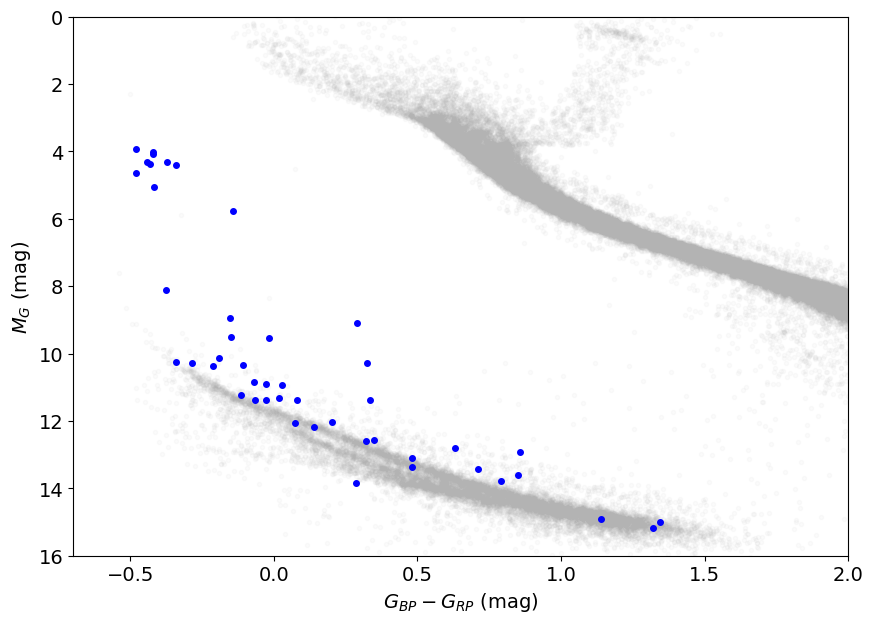

In [11]:
gmags_hvs = abs_mag(df_hvs['phot_g_mean_mag'], df_hvs['parallax'])
gmags_100pc = abs_mag(df_100pc['phot_g_mean_mag'], df_100pc['parallax'])

fig = plt.figure(figsize=(10,7))
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_{G}$ (mag)')
plt.ylim(0,16)
plt.xlim(-0.7,2.0)
plt.gca().invert_yaxis()
plt.scatter(df_100pc['bp_rp'], gmags_100pc, marker='.', color='0.7', alpha=0.05)
plt.plot(df_hvs['bp_rp'], gmags_hvs, 'bo', markersize=4)
plt.show()

Compare the above plot with Figure 1 in [Igoshev et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.6223I/abstract). Gaia DR3 objects within 100 pc of the sun are plotted in greyscale for reference, where part of the main sequence is seen between $M_{G}\approx 0$ and $M_{G}\approx 9$ and part of the white dwarf sequence is seen between $M_{G}\approx 10$ and $M_{G}\approx 16$. The HVS WD candidates plotted in blue can be split into three different groups:

1. WD-like objects located on or just above the WD sequence
2. Hot subdwarf B-like objects gathered around $M_{G}\approx 4$ and $G_{BP}-G_{RP}\approx -0.4$
3. Objects located between the WD sequence and main sequence

Some hot subdwarf O and B stars are identified as hyper-velocity sources (see [Heber 2009](https://ui.adsabs.harvard.edu/abs/2009ARA%26A..47..211H/abstract), for a review and references). Furthermore, up to 20% of sdB stars reside in the Milky Way halo ([Napiwotzki 2008](https://myasp.astrosociety.org/product/CS392/vol-392-hot-subdwarf-stars-and-related-objects)), so their velocities are expected to be hundreds of km/s with respect to the local standard of rest (LSR) of the thin disc. The authors classify candidates with $4 \le M_{G} \le 6$ and $-0.5 \le G_{BP}-G_{RP} \le -0.25$ as HVsdBC, that is, high-velocity sdB candidates.

<a class="anchor" id="galacto"></a>
## Galactocentric distances and heights above/below the Galactic plane for HVS WD candidates

We can use the parallax and galactic coordinates from Gaia DR3 to compute the Galactocentric position of each HVS WD candidate. The Galactocentric position in cylindrical coordinates has the following three components: the Galactocentric distance $R$, the Galactocentric azimuth $\phi$ (not used in this notebook), and the vertical distance $Z$. The conversion formulas are the following ([López-Corredoira et al. 2000](https://ui.adsabs.harvard.edu/abs/2000MNRAS.313..392L/abstract)):

$r=\frac{1AU}{parallax}$  
$X(r,l,b) = R_{\odot} - r\cos l \cos b$  
$Y(r,l,b) = r \sin l \cos b$  
$Z(r,b) = r \sin b$  
$R(r,l,b) = \sqrt{X^{2}+Y^2}$  

We assume the radius of the sun to be $R_{\odot}$ = 8.5 kpc

$X$ and $Y$ are Cartesian coordinates, measured in parsecs. $R$ and $Z$ are cylindrical coordinates in kpc. $l$ and $b$ stand for the galactic longitude and galactic latitude in degrees, respectively. $r$ is the distance to the star in parsecs given the parallax in arcseconds.

In [12]:
def galactocentric(parallax, l, b):
    "Calculate the Galactocentric distance and vertical distance."
    l = np.deg2rad(l)
    b = np.deg2rad(b)
    R_sun = 8.5
    r = 1/parallax
    X = R_sun - r*np.cos(l)*np.cos(b)
    Y = r*np.sin(l)*np.cos(b)
    Z = r*np.sin(b)
    R = np.sqrt(X**2 + Y**2)
    return R, Z

In [13]:
R, Z = galactocentric(df_hvs['parallax'], df_hvs['l'], df_hvs['b'])

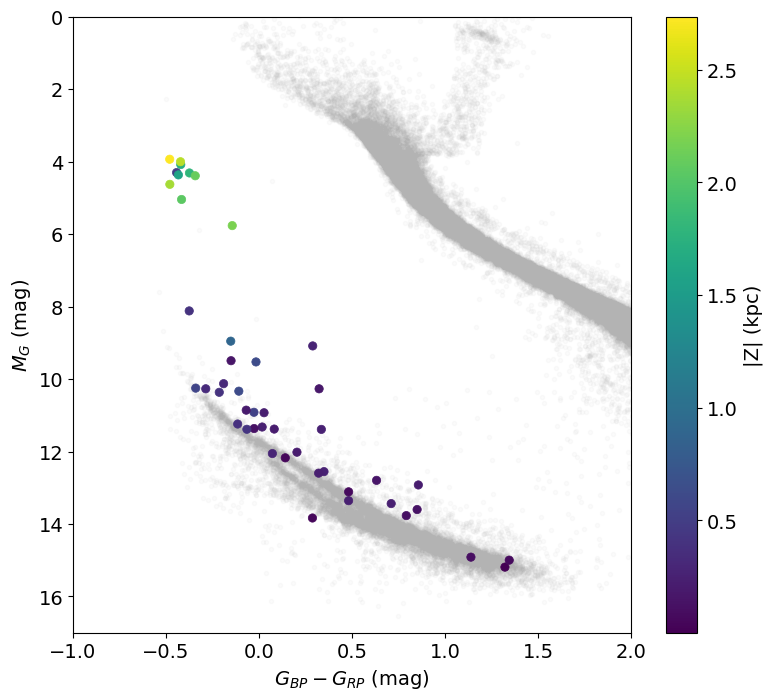

In [14]:
fig = plt.figure(figsize=(9,8))
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_{G}$ (mag)')
plt.xlim(-1.0,2.0)
plt.ylim(0,17)
plt.gca().invert_yaxis()
plt.scatter(df_100pc['bp_rp'], gmags_100pc, marker='.', color='0.7', alpha=0.05)
plt.scatter(df_hvs['bp_rp'], gmags_hvs, c=[abs(Zs) for Zs in Z], linewidths=0.5)
cbar = plt.colorbar(label='|Z| (kpc)')

Compare the above plot with Figure 3 in [Igoshev et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.6223I/abstract). This plot shows the location of the HVS WD candidates on the HR diagram, colored by the absolute vertical distance above/below the Galactic disc. Gaia DR3 objects within 100 pc of the sun are plotted in greyscale for reference, where part of the main sequence is seen between $M_{G}\approx 0$ and $M_{G}\approx 9$ and part of the white dwarf sequence is seen between $M_{G}\approx 10$ and $M_{G}\approx 16$. Note that in their Figure 3, the authors used a custom approach to deredden their HVS WD candidates. We decided not to follow that same approach since the difference in values are diminutive. 

<a class="anchor" id="heights"></a>
## Heights above the Galactic plane of the observed HVS WD candidates

In order to potentially provide an alternative age estimate for the candidates whose WD cooling ages and total ages couldn't be estimated because their masses were lower than 0.5 solar masses and could not form through normal stellar evolution of a single stellar progenitor over a Hubble time, the authors plot the heights of the observed HVS WDs above/below the Galactic disc. In [Casagrande et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.455..987C/abstract), it is shown most stars that reside below 1 kpc from the Galactic plane are younger than the 10 Gyr age of halo stars. We can see from the plot below that most of our HVS WD candidates are located below 1 kpc (red dashed line) from the plane, which is consistent with a disc origin for the majority of the sample and would require a non-trivial velocity kick. However, further study of the radial velocities are needed to better constrain/confirm their origin.

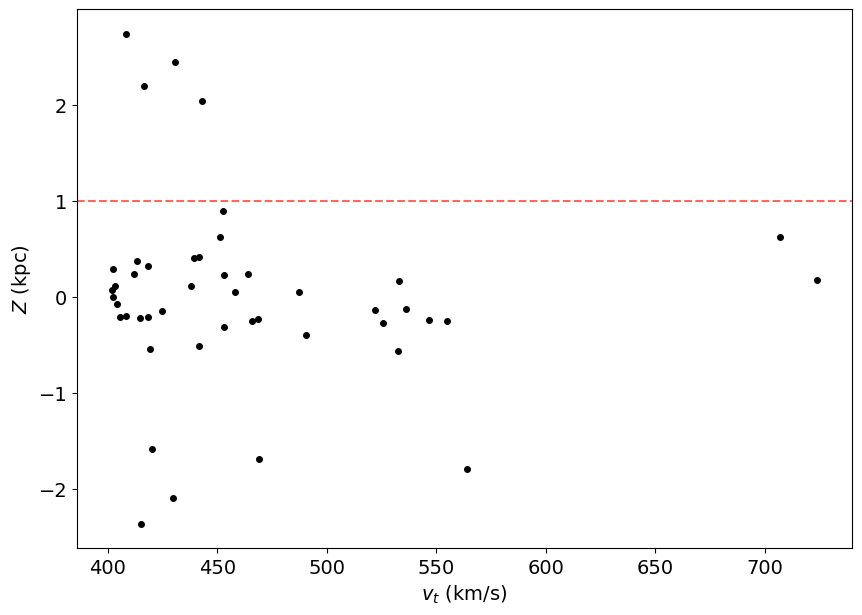

In [15]:
fig = plt.figure(figsize=(10,7))
plt.xlabel('$v_{t}$ (km/s)')
plt.ylabel('$Z$ (kpc)')
plt.plot(df_hvs['v'], Z, 'ko', markersize=4)
plt.axhline(y = 1, color = 'r', linestyle = '--', alpha=0.6)
plt.show()

Compare the above plot with Figure 4 in [Igoshev et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.6223I/abstract). This plot shows the spread of transversal velocities and vertical distances above the Galactic plane for HVS WD candidates. Stars below the dashed red line are considered to be younger than the 10 Gyr age of halo stars ([Casagrande et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.455..987C/abstract)) and may indicate a disc origin. 

<a class="anchor" id="ref"></a>
## Resources and references

Casagrande et al. 2016, "Measuring the vertical age structure of the Galactic disc using asteroseismology and SAGA", MNRAS, 455, 987. https://doi.org/10.1093/mnras/stv2320

Gentile Fusillo, N. P. et al. 2021, "A catalogue of white dwarfs in Gaia EDR3", MNRAS, 508, 3877. https://doi.org/10.1093/mnras/stab2672

Heber 2009, "Hot Subdwarf Stars", ARA&A, 47, 211. https://www.annualreviews.org/doi/10.1146/annurev-astro-082708-101836

Igoshev et al. 2023, "Hyper-runaway and hypervelocity white dwarf candidates in Gaia Data Release 3: Possible remnants from Ia/Iax supernova explosions or dynamical encounters", MNRAS, 518, 6223. https://doi.org/10.1093/mnras/stac3488

López-Corredoira, M. et al. 2000, "Inversion of stellar statistics equation for the Galactic bulge", MNRAS, 313, 392. https://doi.org/10.1046/j.1365-8711.2000.03220.x

Napiwotzki R., 2008, in Heber U., Jeffery C. S., Napiwotzki R., eds, Astronomical Society of the Pacific Conference Series Vol. 392, Hot Subdwarf Stars and Related Objects. p. 139